In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from src import utils, plots, metrics, mlp

In [3]:
nn = torch.nn
F = torch.nn.functional

In [4]:
utils.set_seed(2022)
torch.backends.cudnn.benchmarks = False
torch.backends.cudnn.deterministic = True
torch.use_deterministic_algorithms(True)

In [58]:
# # hyperparams

# data
N = 21000
sigmas = [0.2, 0.8, 5]
alphas = [0.2, 0.8, 5]

# train
epochs = 500
batch_size = 512

# optim
lr = 1e-3
momentum = 0.99
weight_decay = 2e-3

In [6]:
def split_dataset(X, X_unif, X_ood):
    train, test, X_ood_unif, _, _, X_ood_test = train_test_split(
        X, X_unif, X_ood, test_size=0.1, random_state=2020)
    
    X_train = torch.from_numpy(train[:, :2]).float()
    y_train = torch.from_numpy(train[:, 2:]).long()
    X_test = torch.from_numpy(test[:, :2]).float()
    y_test = torch.from_numpy(test[:, 2:]).long()
    X_ood_unif = torch.from_numpy(X_ood_unif).float()
    X_ood_test = torch.from_numpy(X_ood_test).float()   
    
    return X_train, y_train, X_test, y_test, X_ood_unif, X_ood_test

In [7]:
# Generate training data
def generate_training_data(N, sigma):
    X, X_ood_unif = utils.generate_toy_dataset(N=N, sigma=sigma, use_torch=False)
    
    N = int(X.shape[0] / 4)
    X_ood_test = utils.generate_ood_multiclass(N=N, sigma=sigma, use_torch=False)
    
    X_train, y_train, X_test, y_test, X_ood_unif, X_ood_test = split_dataset(
        X, X_ood_unif, X_ood_test)
    
    return X_train, y_train, X_test, y_test, X_ood_unif, X_ood_test

In [8]:
# generate 3 datasets with varying std for training and testing
X_train, y_train, X_test, y_test, X_ood_train, X_ood_test = generate_training_data(
    N, sigmas[0])

train_data = [X_train, y_train, X_ood_train]
test_data = [X_test, y_test, X_ood_test]

In [9]:
datasets = train_data + test_data
datasets = [datasets[i] for i in [0, 1, 3, 4, 2, 5]]
y_ood_train = "#2077B4"
y_ood_test = "#FDE724"
datasets.insert(5, y_ood_train)
datasets.append(y_ood_test)
datasets += [np.vstack([X_test, X_ood_test]), np.vstack([y_test, np.ones((len(X_ood_test), 1))*3])]
datasets = [(datasets[i], datasets[i+1]) for i in range(len(datasets))[::2]]

Train:  torch.Size([56700, 2])
Test:  torch.Size([6300, 2])
Train OOD:  torch.Size([56700, 2])
Test OOD:  torch.Size([6300, 2])


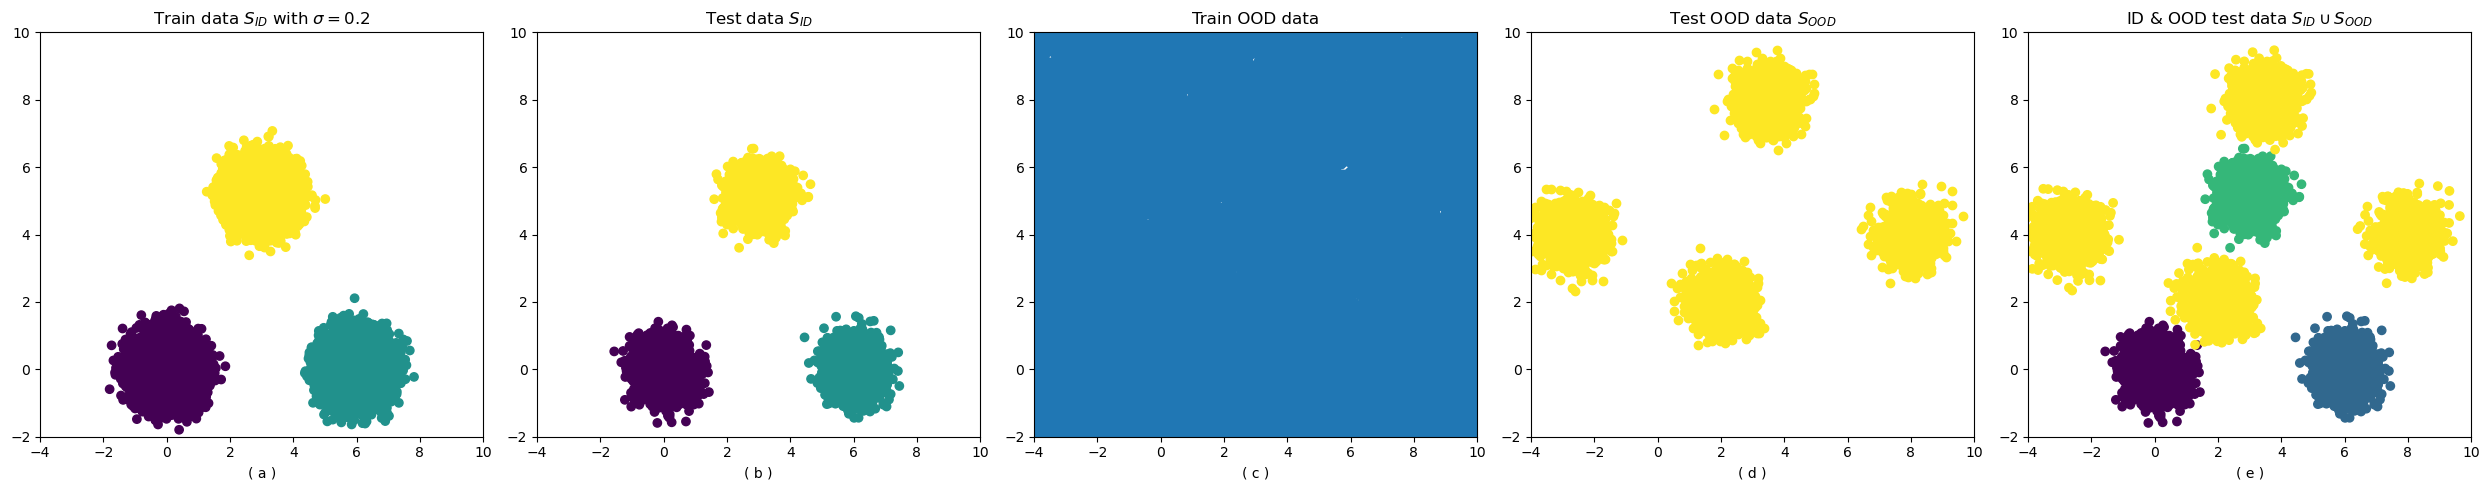

In [10]:
print("Train: ", X_train.shape)
print("Test: ", X_test.shape)
print("Train OOD: ", X_ood_train.shape)
print("Test OOD: ", X_ood_test.shape)

titles = ["Train data $S_{ID}$ with $\sigma=0.2$", 
          "Test data $S_{ID}$",
          "Train OOD data",
          "Test OOD data $S_{OOD}$",
         "ID & OOD test data $S_{ID} \cup S_{OOD}$"]
xlabels = ["( a )", "( b )", "( c )", "( d )", "( e )"]

fig, axs = plt.subplots(1, 5, figsize=(25, 5))
for ax, label, title, data in zip(axs, xlabels, titles, datasets):
    ax.set_ylim([-2, 10])
    ax.set_xlim([-4, 10])
    ax.set_xlabel(label)
    ax.set_title(title)
    x, y = data
    plots.plot_x(x, ax=ax, labels=y)

fig.tight_layout()

In [11]:
def cross_entropy(logits, y, batch_size):
    logits, logits_ood = torch.split(logits, batch_size)
    loss = F.cross_entropy(logits, y)
    probs = F.softmax(logits, dim=1)
    y_hat = probs.argmax(dim=1, keepdim=True)
    return loss, y_hat

In [12]:
def contrastive_regularised(logits, y, batch_size, lamda=-1):
    probs, probs_ood = F.softmax(logits, dim=1).split(batch_size)
    CE, _ = cross_entropy(logits, y, batch_size)
    cosine = F.cosine_similarity(probs, probs_ood, dim=1).mean()
    loss = 2 * CE + (lamda * cosine)
    y_hat =  probs.argmax(dim=1)
    return loss, y_hat

In [13]:
def contrastive_ranking(logits, y, batch_size, gamma=torch.tensor([1.0]), n_classes=3):
    zero = torch.tensor([0.0])
    probs, probs_ood = F.softmax(logits, dim=1).split(batch_size)
    cosine = F.cosine_similarity(probs, probs_ood, dim=1).mean()
    l1 = 0.005 * (probs_ood - 1/n_classes).abs().sum()
    l2 = 0.007 * ((probs[range(batch_size), y] - 0.9954)**2).sum()
    margin = torch.maximum(zero, gamma + cosine)
    loss = margin + l1 + l2
    y_hat = probs.argmax(dim=1)
    return loss, y_hat

In [14]:
def test(model, data):
    X_test, y_test, X_ood_test = data
    test_loss = 0.0
    correct = 0.0
    n_samples = 0.0
    model.eval()
    with torch.no_grad():
        for i in range(len(X_test) // batch_size):
            x = X_test[i*batch_size: (i+1)*batch_size]
            y = y_test[i*batch_size: (i+1)*batch_size]
            y = y.view(-1)
            # x_ood = X_ood_test[i*batch_size: (i+1)*batch_size]
            logits = model(x)
            probs = F.log_softmax(logits, dim=1)
            test_loss += F.nll_loss(probs, y, reduction='sum').item()  # sum up batch loss
            y_hat = probs.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += y_hat.eq(y.view_as(y_hat)).sum().item()
            n_samples += len(logits)

    test_loss /= n_samples

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, n_samples, 100. * correct / n_samples)) 

In [15]:
def train(model, opt, data, loss_fn, verbose=False):
    losses, accuracies = [], []
    X_train, y_train, X_ood_train = data
    n_minibatches = len(X_train) // batch_size
    model.train()
    for epoch in tqdm(range(epochs)):
        error = 0.0
        correct = 0.0
        for i in range(n_minibatches):
            x = X_train[i*batch_size: (i+1)*batch_size]
            y = y_train[i*batch_size: (i+1)*batch_size]
            y = y.view(-1)
            x_ood = X_ood_train[i*batch_size: (i+1)*batch_size]
            x_stack = torch.vstack([x, x_ood])
            logits = model(x_stack)
            loss, y_hat = loss_fn(logits, y, len(x))
            correct += y_hat.eq(y.view_as(y_hat)).sum().item()
            error += loss.item() * len(x)

            opt.zero_grad()
            loss.backward()
            opt.step()

        losses.append(error / len(X_train))
        accuracies.append(correct / len(X_train))
        if epoch % 25 == 0:
            if verbose:
                print("Epoch: {} Loss: {}".format(epoch, np.mean(losses)))
    return losses, accuracies

In [16]:
def test(model, data, dropout=False):
    X_test, y_test, X_ood_test = data
    correct, correct_ood = 0.0, 0.0
    n_samples = 0.0
    model.eval()
    with torch.no_grad():
        for i in range(len(X_test) // batch_size):
            x = X_test[i*batch_size: (i+1)*batch_size]
            y = y_test[i*batch_size: (i+1)*batch_size]
            y = y.view(-1)
            x_ood = X_ood_test[i*batch_size: (i+1)*batch_size]
            x_stack = torch.vstack([x, x_ood])
            logits = utils.average_predictions(model, x_stack, y) if dropout else model(x_stack)
            y_hat = logits.argmax(dim=1, keepdim=True)
            correct += y.eq(y_hat[:batch_size].view_as(y)).sum().item()
            correct_ood += y.eq(y_hat[batch_size:].view_as(y)).sum().item()
            n_samples += batch_size

    print('Test data: Accuracy: {}/{} ({:.2f}%)\n'.format(
        correct, n_samples, 100. * correct / n_samples))
    print('Test OOD data: Accuracy: {}/{} ({:.2f}%)\n'.format(
        correct_ood, n_samples, 100. * correct_ood / n_samples))

In [17]:
# define network and optim
def construct_net(dropout=0):
    net = mlp.MLP(input_dim=2, hidden_dim=50, output_dim=3, dropout_rate=dropout)
    opt = torch.optim.SGD(net.parameters(), lr, momentum, weight_decay)
    return net, opt

In [18]:
def compute_metrics(model, X_test, X_ood_test):
    model.eval()
    with torch.no_grad():
        metrics_id = metrics.uncertainty_metrics(model(X_test).numpy())
        metrics_ood = metrics.uncertainty_metrics(model(X_ood_test).numpy())

    for string in ['confidence', 'entropy_of_conf', 'mutual_information']:
        y_test_in, y_test_ood = len(metrics_id[string]), len(metrics_ood[string])
        if string == "confidence":
            y_true = np.r_[np.ones(y_test_in), np.zeros(y_test_ood)]
            y_scores = np.r_[metrics_id[string], metrics_ood[string]]
        else:
            y_true = np.r_[np.ones(y_test_ood), np.zeros(y_test_in)]
            y_scores = np.r_[metrics_ood[string], metrics_id[string]]

        print("ROC values:\n {} = {},\n".format(string, roc_auc_score(y_true,  y_scores)))
    return metrics_id, metrics_ood

In [19]:
def plot_histogram(metrics_id, metrics_ood):
    f, ax = plt.subplots(1, 3, figsize=(15, 5))
    for i, string in enumerate(['confidence', 'entropy_of_conf', 'mutual_information']):
#         ax[i].set_xscale('log')
        ax[i].hist(metrics_id[string], bins=np.linspace(0, 3, 25), label='Test', alpha=0.5)
        ax[i].hist(metrics_ood[string], bins=np.linspace(0, 3, 25), label='OoD', alpha=0.5)
        ax[i].legend()
        ax[i].set_title(string)

In [20]:
def plot_boundaries(model, X_test, y_test, X_ood_test, dropout=False):
    fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(25, 10))
    for ax in axs.flatten():
        ax.set_ylim([-2, 10])
        ax.set_xlim([-5, 10])

    y_ood_test_dummy = np.ones((len(X_ood_test), 1)) * 4
    test_sets = [[X_test, y_test], [X_ood_test, y_ood_test_dummy]]

    for i, test_set in enumerate(test_sets):
        X_te, y_te = test_set
        grid, x_coord, y_coord = utils.create_meshgrid(X_te)  # this creates a mesh grid
        test_data_grid =  torch.from_numpy(grid.astype(np.float32))
        model.eval()
        with torch.no_grad():
            if dropout:
                logits = utils.average_predictions(model, test_data_grid, y_te, n_classes=3, n_models=30)
            else:
                logits = model(test_data_grid)
            logits = np.asarray(logits)
            X_te = np.asarray(X_te)
            y_te = np.asarray(y_te)
            plots.plot_net(logits, X_te, y_te, x_coord, y_coord, axs[i], fig, sigma=sigmas[i])
    fig.tight_layout()

### Create network, train and plot metrics: CrossEntropy Baseline

In [21]:
# construct network
model, opt = construct_net()

In [22]:
# Train the networks
losses, accuracies = train(model, opt, train_data, cross_entropy)

  0%|          | 0/400 [00:00<?, ?it/s]

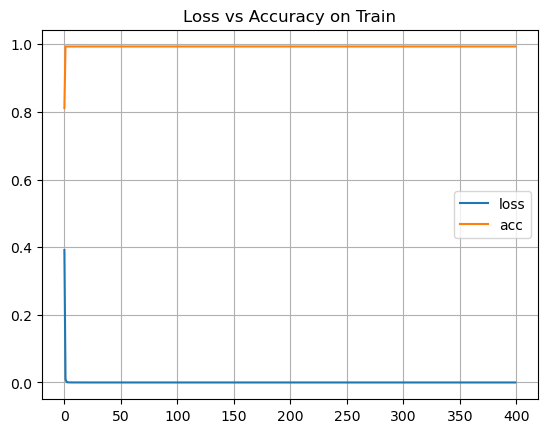

In [23]:
plots.plot_train_stats(epochs, losses, accuracies)

In [24]:
test(model, test_data)

Test data: Accuracy: 6144.0/6144.0 (100.00%)

Test OOD data: Accuracy: 2094.0/6144.0 (34.08%)



In [25]:
metrics_id, metrics_ood = compute_metrics(model, X_test, X_ood_test)

ROC values:
 confidence = 0.7214915343915344,

ROC values:
 entropy_of_conf = 0.7213188460569413,

ROC values:
 mutual_information = 0.7074229528848577,



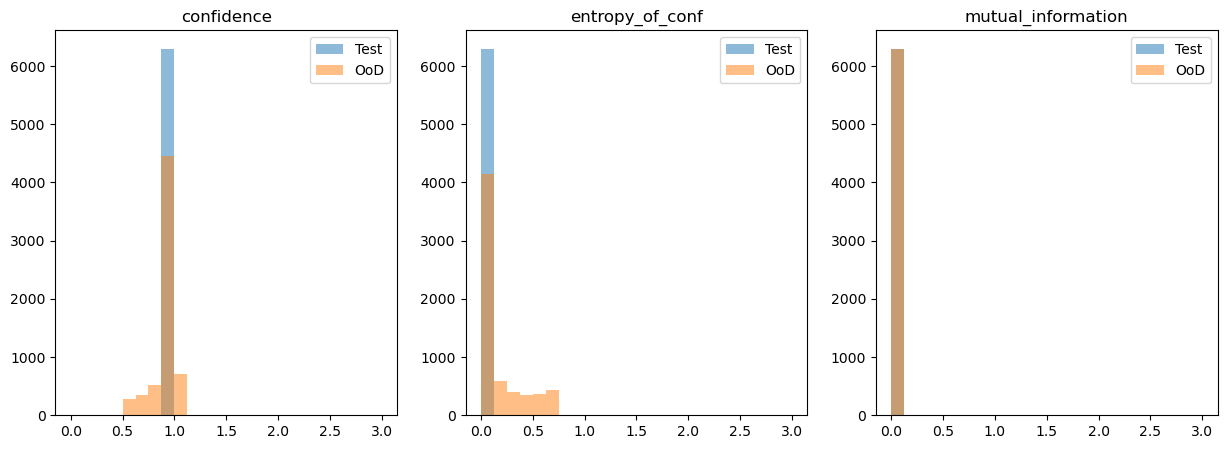

In [26]:
plot_histogram(metrics_id, metrics_ood)

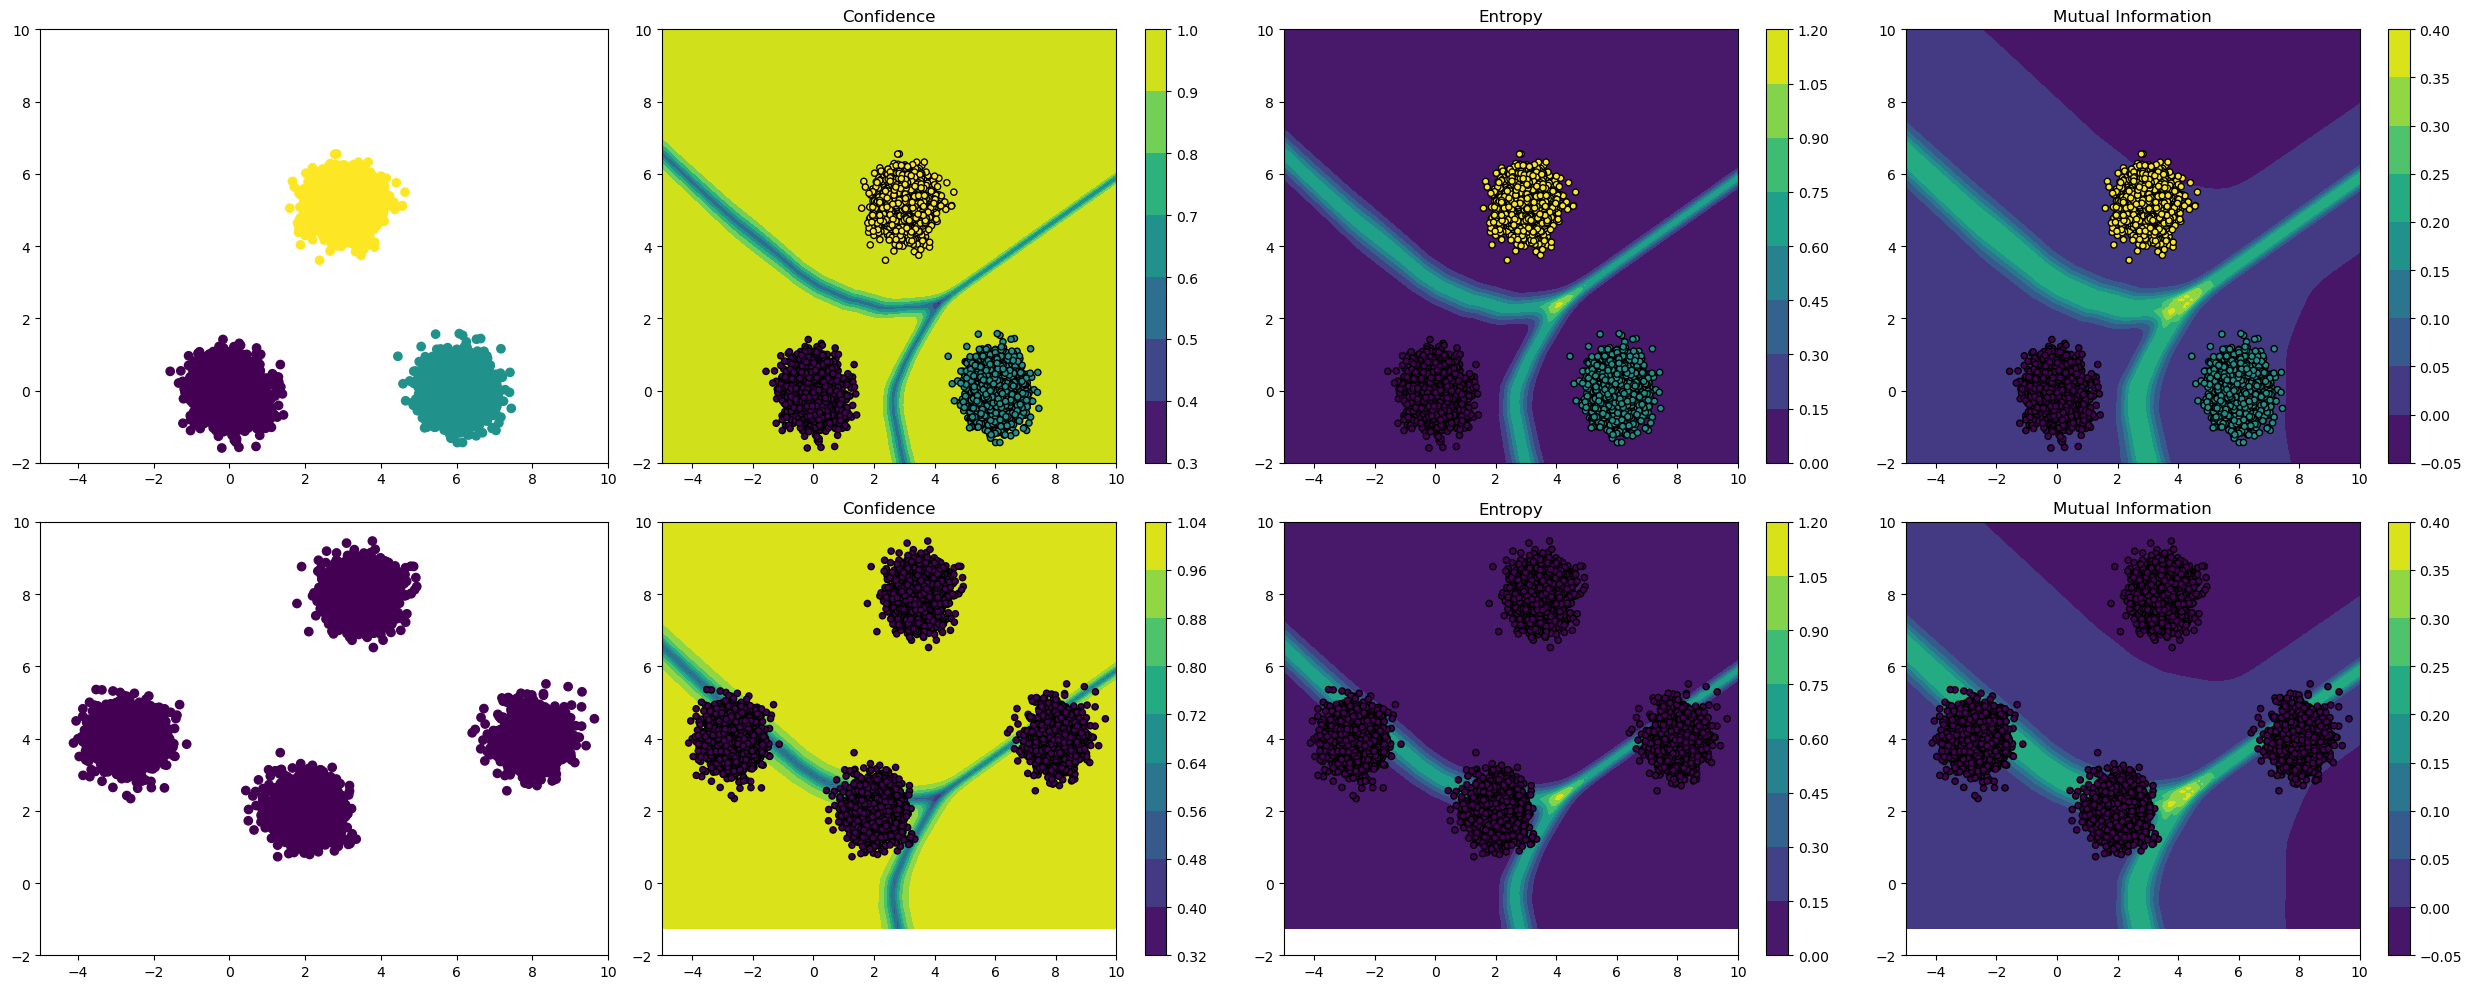

In [27]:
plot_boundaries(model, X_test, y_test, X_ood_test)

### Create network, train and plot metrics: CrossEntropy + MCD

In [28]:
# construct network
model, opt = construct_net(dropout=0.1)

In [29]:
# train and test the model
losses, accuracies = train(model, opt, train_data, cross_entropy)

  0%|          | 0/400 [00:00<?, ?it/s]

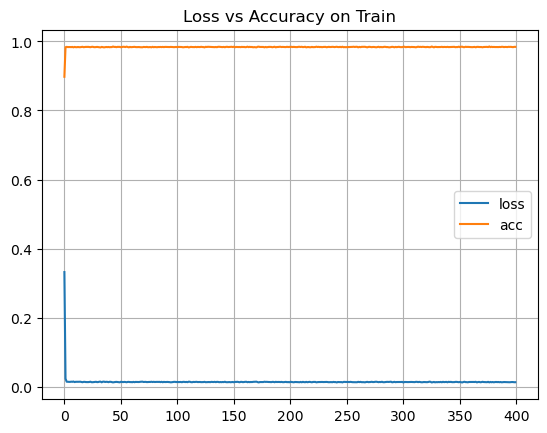

In [30]:
plots.plot_train_stats(epochs, losses, accuracies)

In [31]:
test(model, test_data, dropout=True)

Test data: Accuracy: 6144.0/6144.0 (100.00%)

Test OOD data: Accuracy: 2071.0/6144.0 (33.71%)



In [32]:
metrics_id, metrics_ood = compute_metrics(model, X_test, X_ood_test)

ROC values:
 confidence = 0.7016861174099268,

ROC values:
 entropy_of_conf = 0.701304333585286,

ROC values:
 mutual_information = 0.6961202317964222,



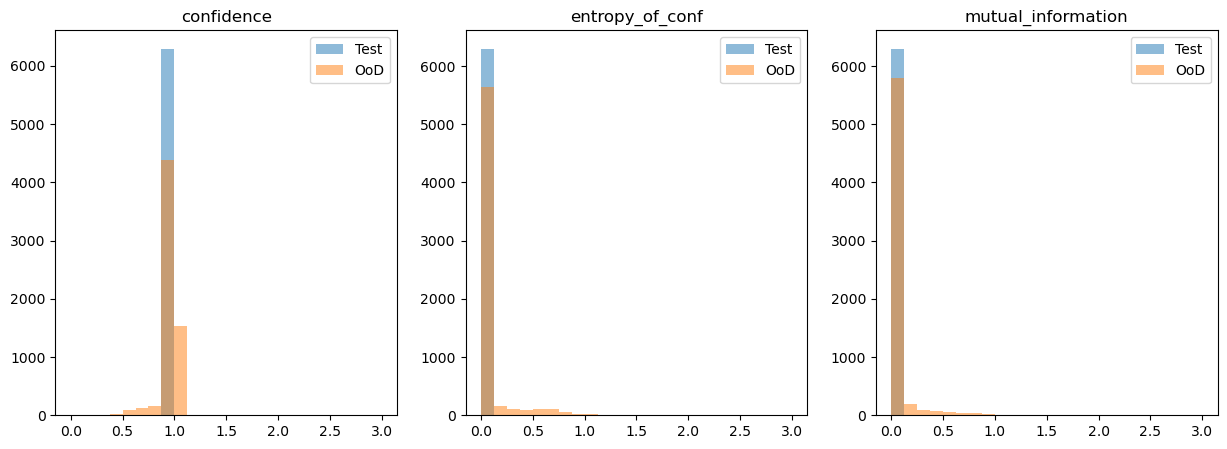

In [33]:
plot_histogram(metrics_id, metrics_ood)

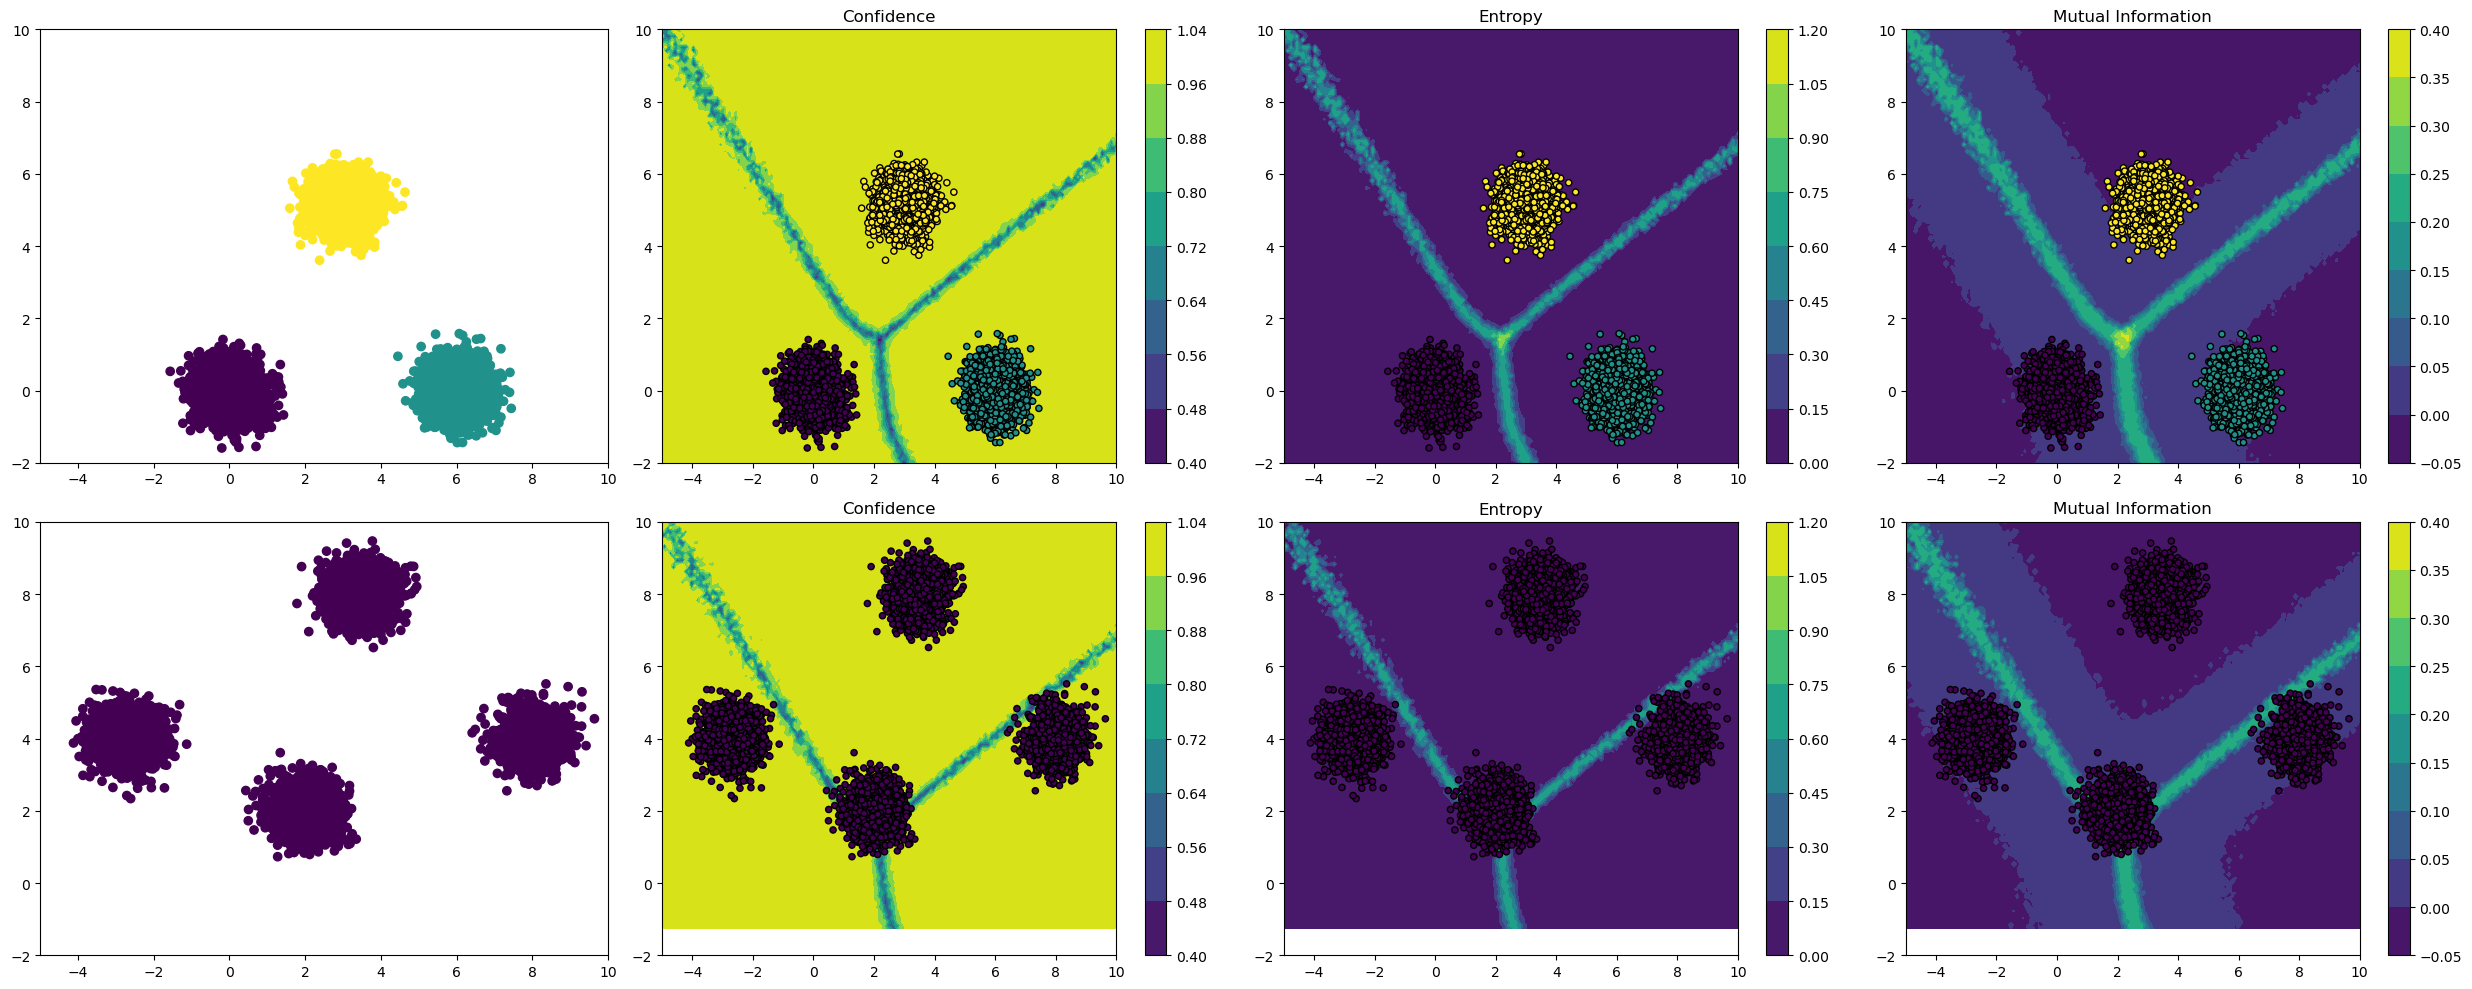

In [34]:
plot_boundaries(model, X_test, y_test, X_ood_test, dropout=True)

### Create network, train and plot metrics: Contrastive Regularised

In [51]:
model, opt = construct_net()

In [52]:
# train and test the model
losses, accuracies = train(model, opt, train_data, contrastive_regularised)

  0%|          | 0/500 [00:00<?, ?it/s]

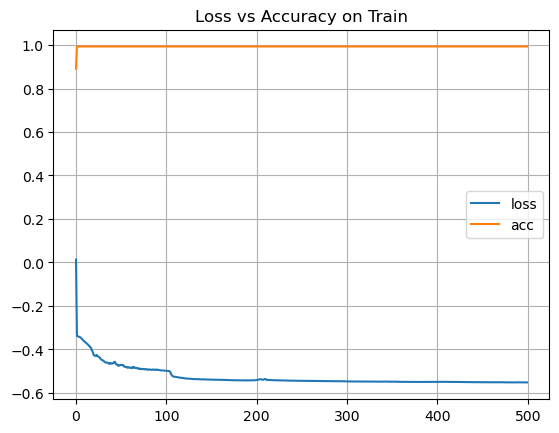

In [53]:
plots.plot_train_stats(epochs, losses, accuracies)

In [54]:
test(model, test_data)

Test data: Accuracy: 6144.0/6144.0 (100.00%)

Test OOD data: Accuracy: 2080.0/6144.0 (33.85%)



In [55]:
metrics_id, metrics_ood = compute_metrics(model, X_test, X_ood_test)

ROC values:
 confidence = 0.9999856135046612,

ROC values:
 entropy_of_conf = 0.9999856135046612,

ROC values:
 mutual_information = 0.9999220206601159,



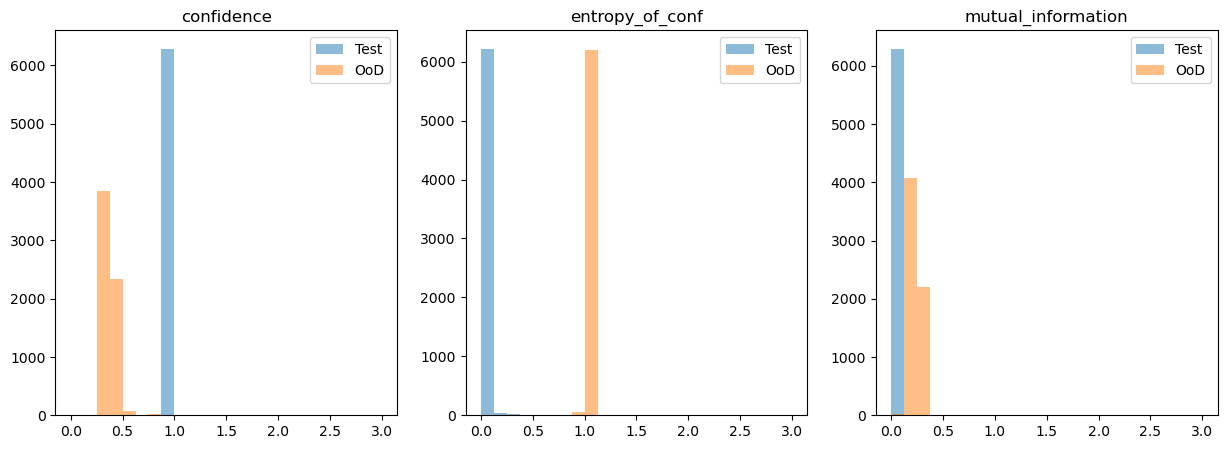

In [56]:
plot_histogram(metrics_id, metrics_ood)

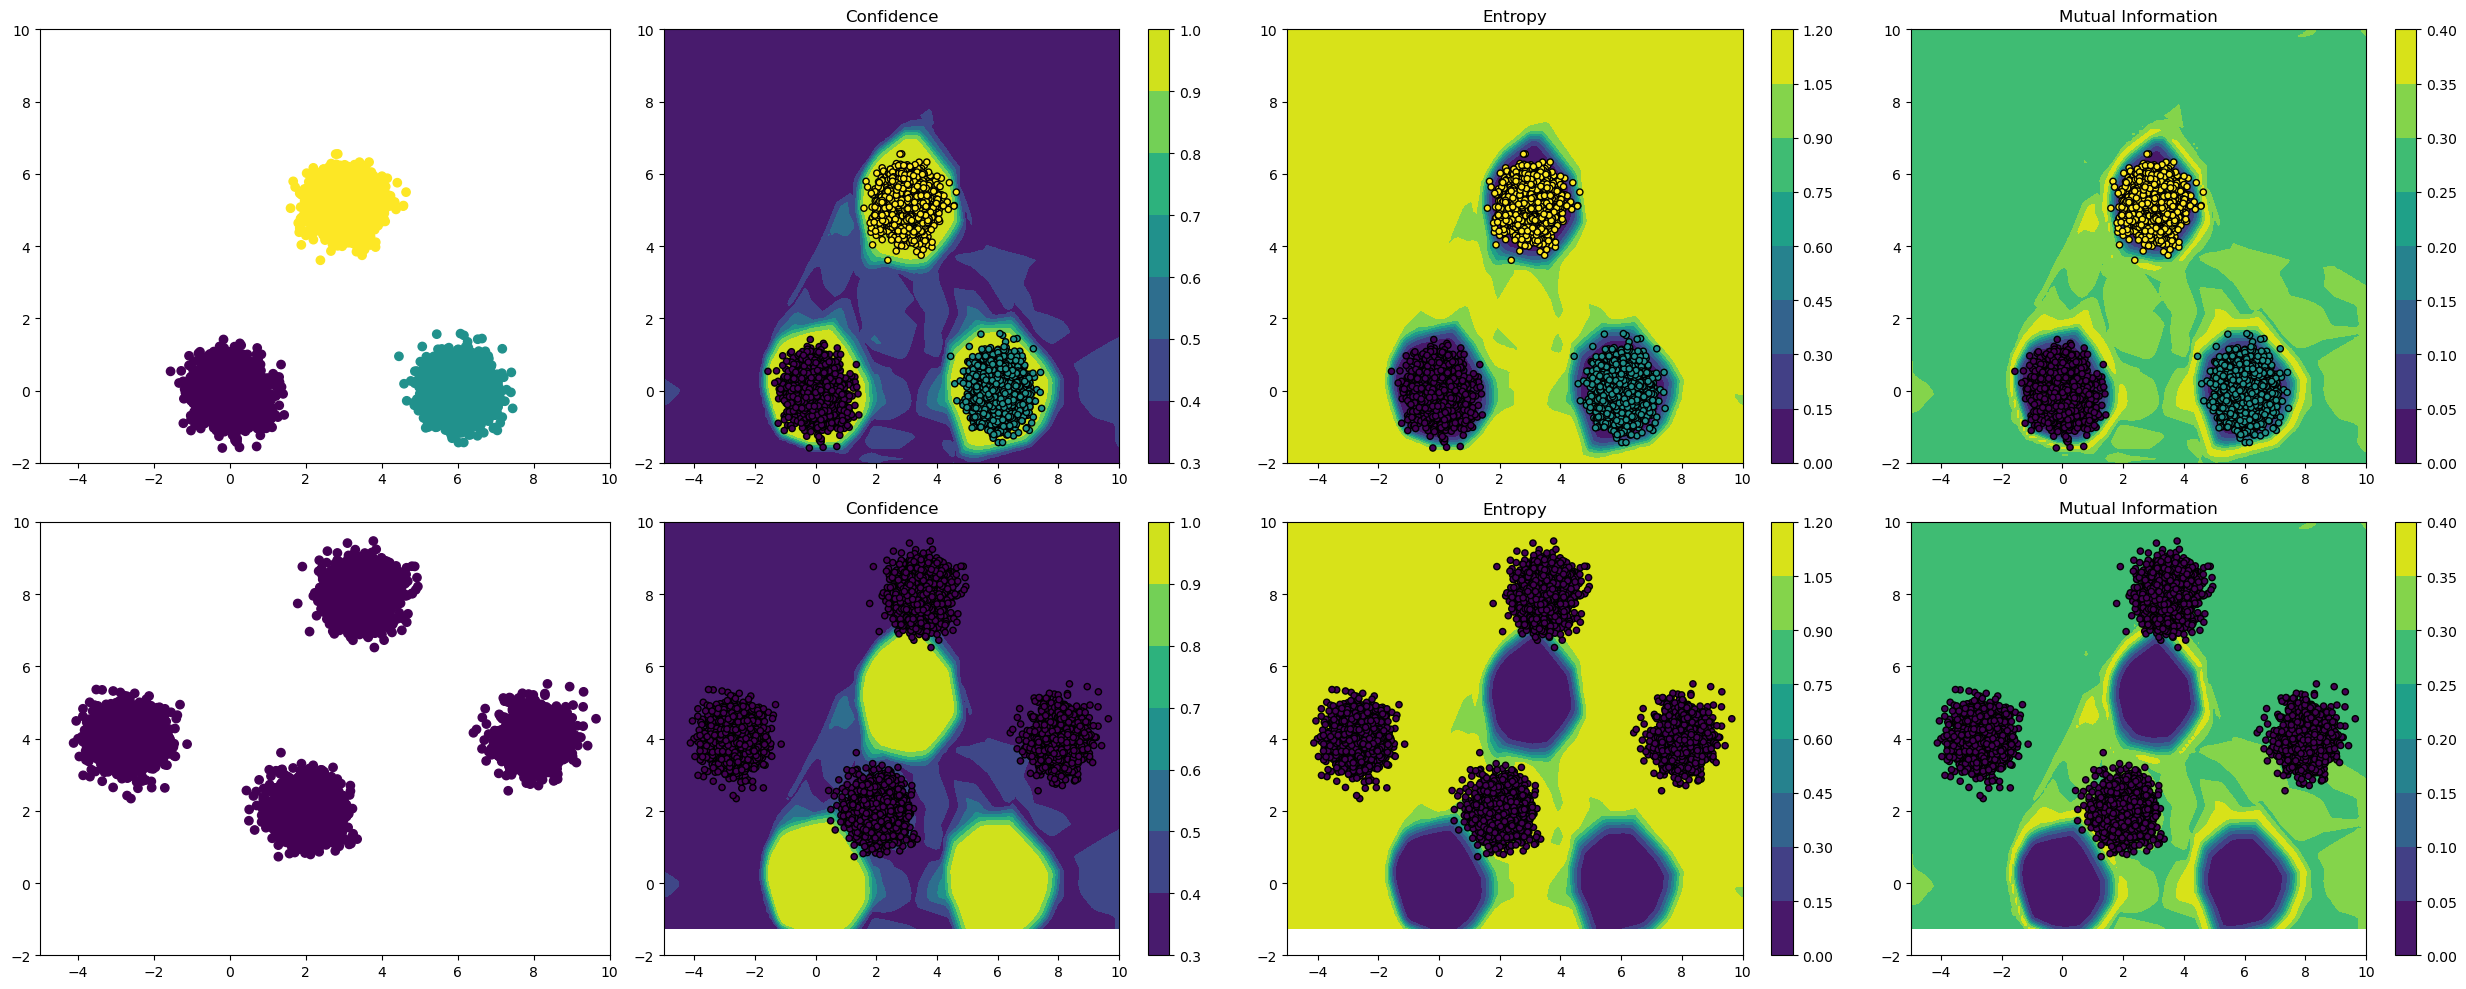

In [57]:
plot_boundaries(model, X_test, y_test, X_ood_test)

### Create network, train and plot metrics: Contrastive Ranking

In [42]:
model, opt = construct_net()

In [43]:
losses, accuracies = train(model, opt, train_data, contrastive_ranking)

  0%|          | 0/400 [00:00<?, ?it/s]

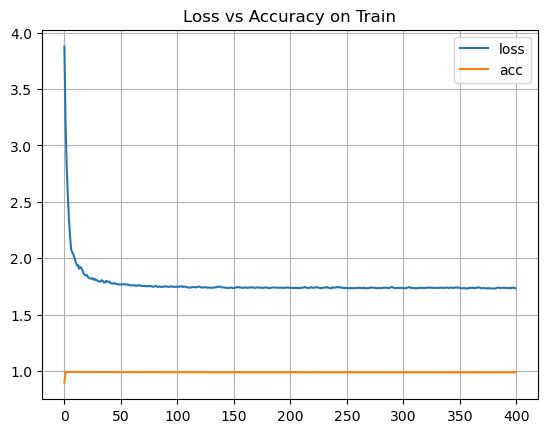

In [44]:
plots.plot_train_stats(epochs, losses, accuracies)

In [45]:
# test the model
test(model, test_data)

Test data: Accuracy: 6109.0/6144.0 (99.43%)

Test OOD data: Accuracy: 1990.0/6144.0 (32.39%)



In [46]:
metrics_id, metrics_ood = compute_metrics(model, X_test, X_ood_test)

ROC values:
 confidence = 0.9955394809775763,

ROC values:
 entropy_of_conf = 0.9971912824389014,

ROC values:
 mutual_information = 0.9954073822121441,



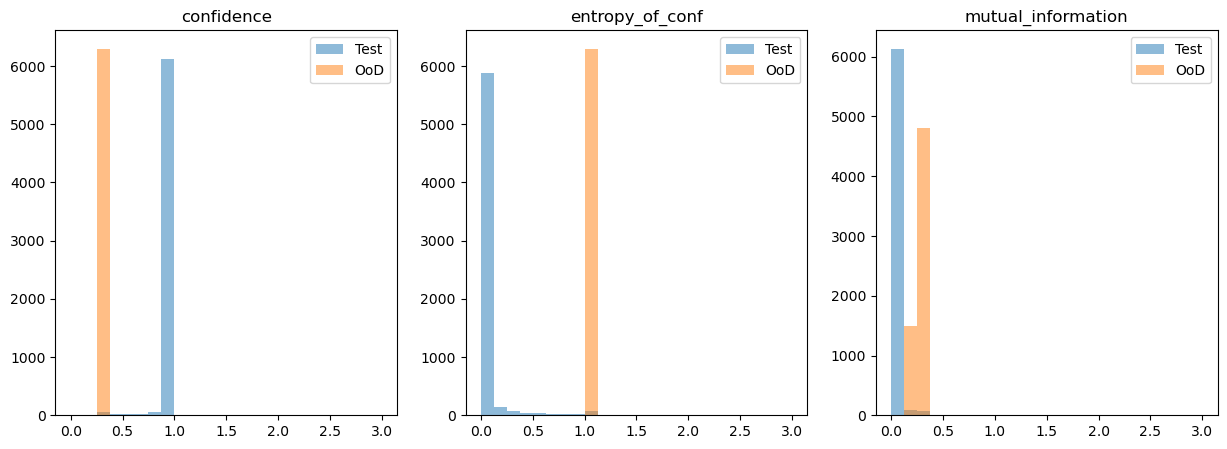

In [47]:
plot_histogram(metrics_id, metrics_ood)

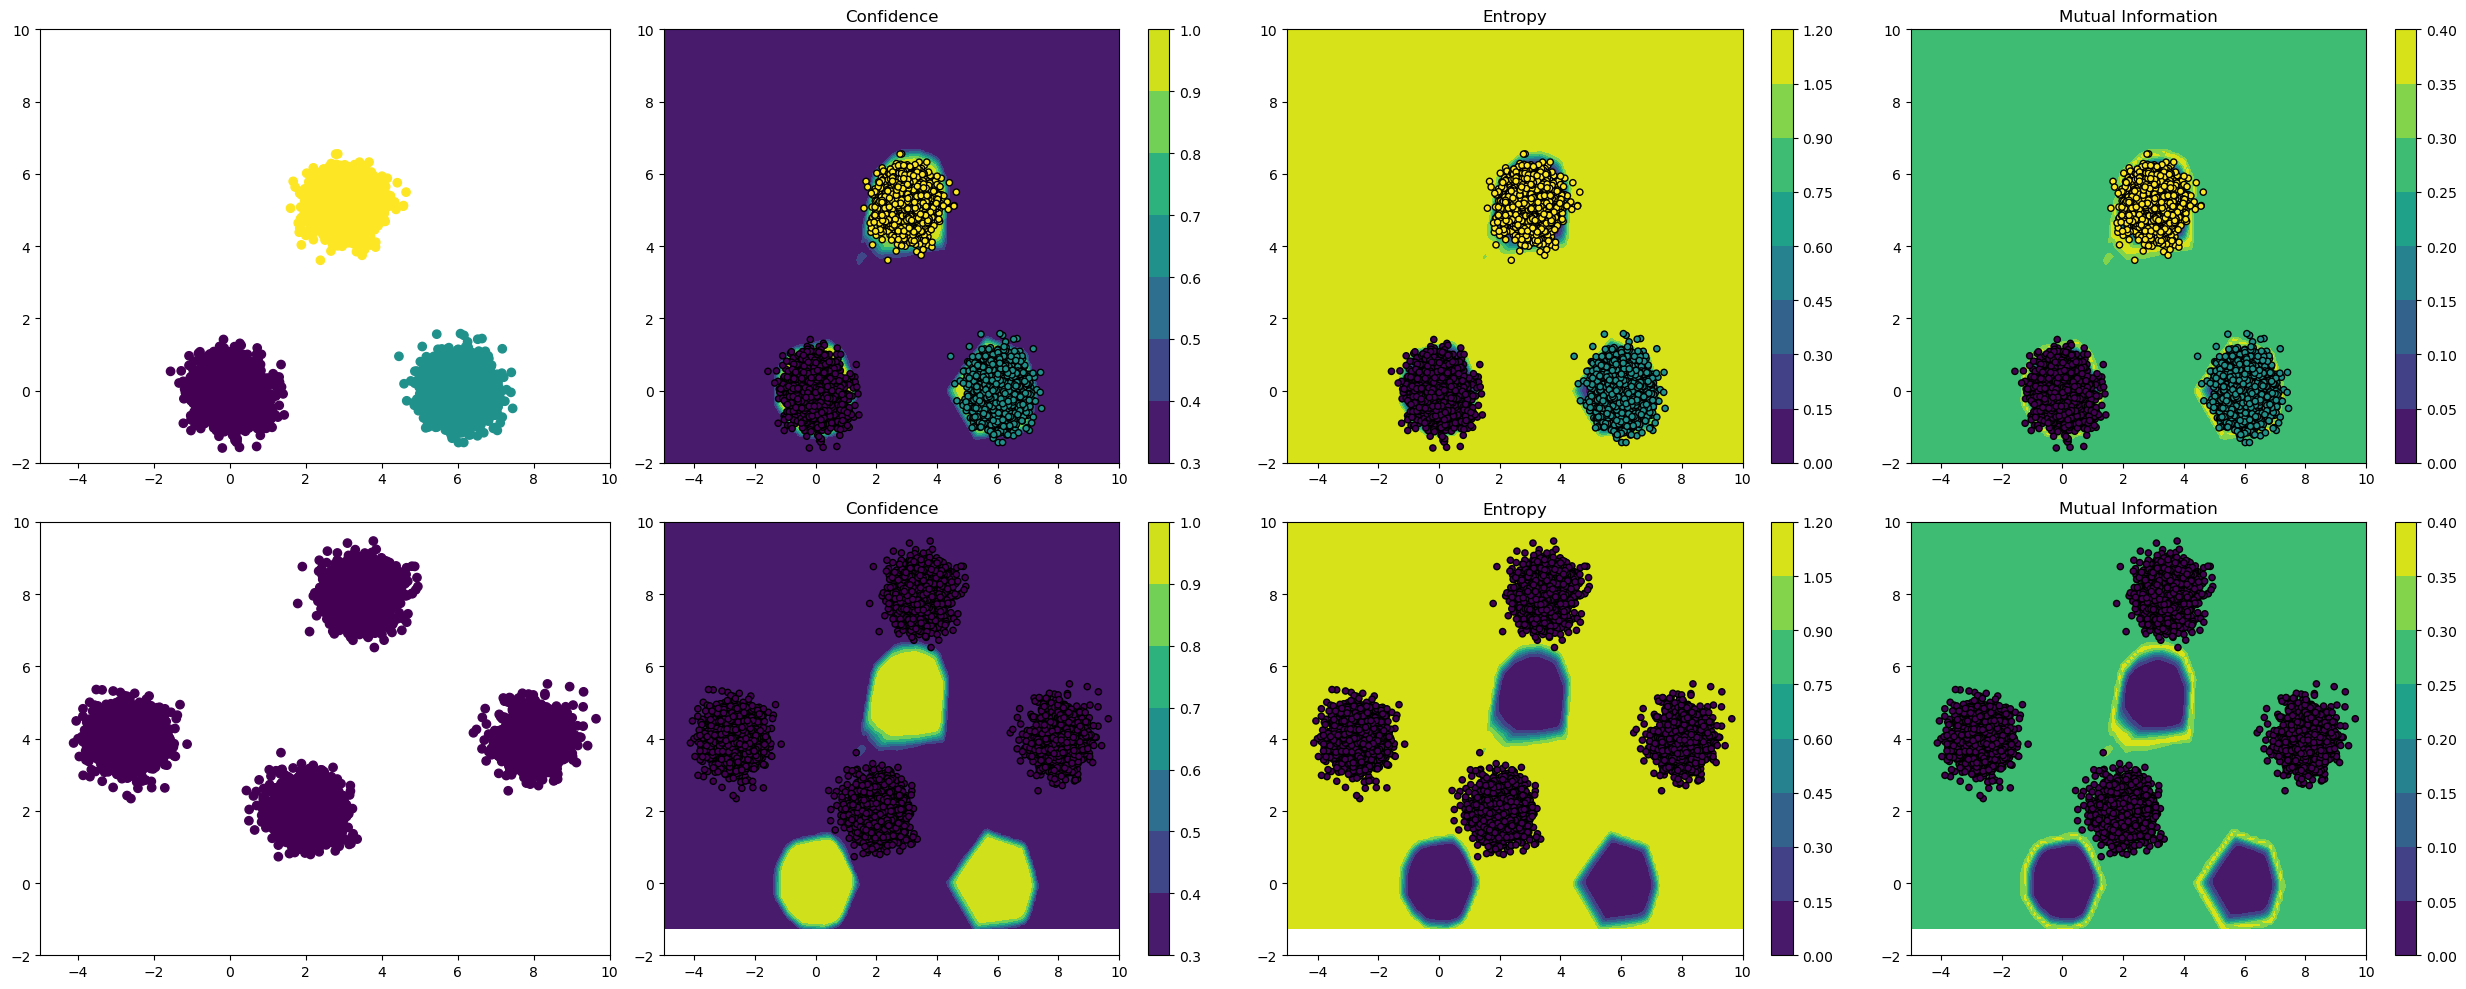

In [48]:
plot_boundaries(model, X_test, y_test, X_ood_test)